# Setup and data import

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [3]:
staticfile = "/home/glemieux/Data/luh2/staticData_quarterdeg.nc"
targetfile = '/home/glemieux/Data/surfdat/surfdata_4x5_16pfts_Irrig_CMIP6_simyr2000_c170824.nc'
clmsurffile = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_surf_deg025.nc'
forestfile = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhforest_deg025.nc'
otherfile = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhother_deg025.nc'
pasturefile = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhpasture_deg025.nc'

In [4]:
ds_static = xr.open_dataset(staticfile)
ds_target = xr.open_dataset(targetfile)
ds_clmsurf = xr.open_dataset(clmsurffile)
ds_forest = xr.open_dataset(forestfile)
ds_other = xr.open_dataset(otherfile)
ds_pasture = xr.open_dataset(pasturefile)
ds_clmlist = [ds_clmsurf,ds_forest,ds_pasture,ds_other]

## Prepare landuse data

Note that the lat/lon dimensions/coordinates for the target are named `lsmlat/lsmlon` and need conversion before comparison or regridding

In [5]:
ds_target = ds_target.rename_dims(dims_dict={'lsmlat':'latitude','lsmlon':'longitude'})
ds_target['longitude'] = ds_target.LONGXY.isel(latitude=0)
ds_target['latitude'] = ds_target.LATIXY.isel(longitude=0)

Convert the clm5 data to lat/lon degrees and create percentage and bareground data

In [6]:
percent = []
bareground = []
for i,ds in enumerate(ds_clmlist):
    # First convert to lat/lon
    ds['lat'] = ds.LAT
    ds['lon'] = ds.LON
    temppercent = ds.PCT_NAT_PFT.isel(natpft=slice(1,None))
    temppercent = temppercent / temppercent.sum(dim='natpft')
    percent.append(temppercent)
    bareground.append(ds.PCT_NAT_PFT.isel(natpft=0))

# TODO: compute prim + secnd percent

# Universal masks

## Regrid target mask

This is the mask that should be applied to the target dataset

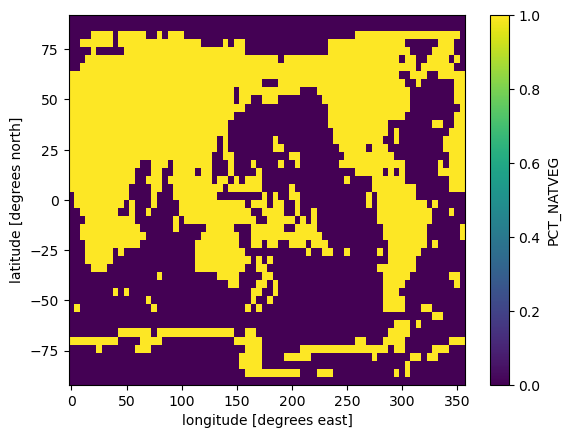

In [7]:
mask_target = xr.where(ds_target.PCT_NATVEG > 0,1,0)
mask_target.plot()

# Ice water from LUH2 static data

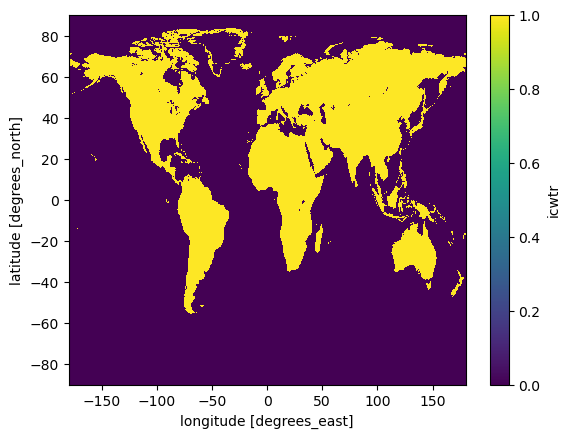

In [15]:
icwtr = ds_static.icwtr.astype('float64')
mask_icwtr = (icwtr != 1)
mask_icwtr.plot()

# Masks by landuse type

## Compute and plot where bareground is 100% for each type

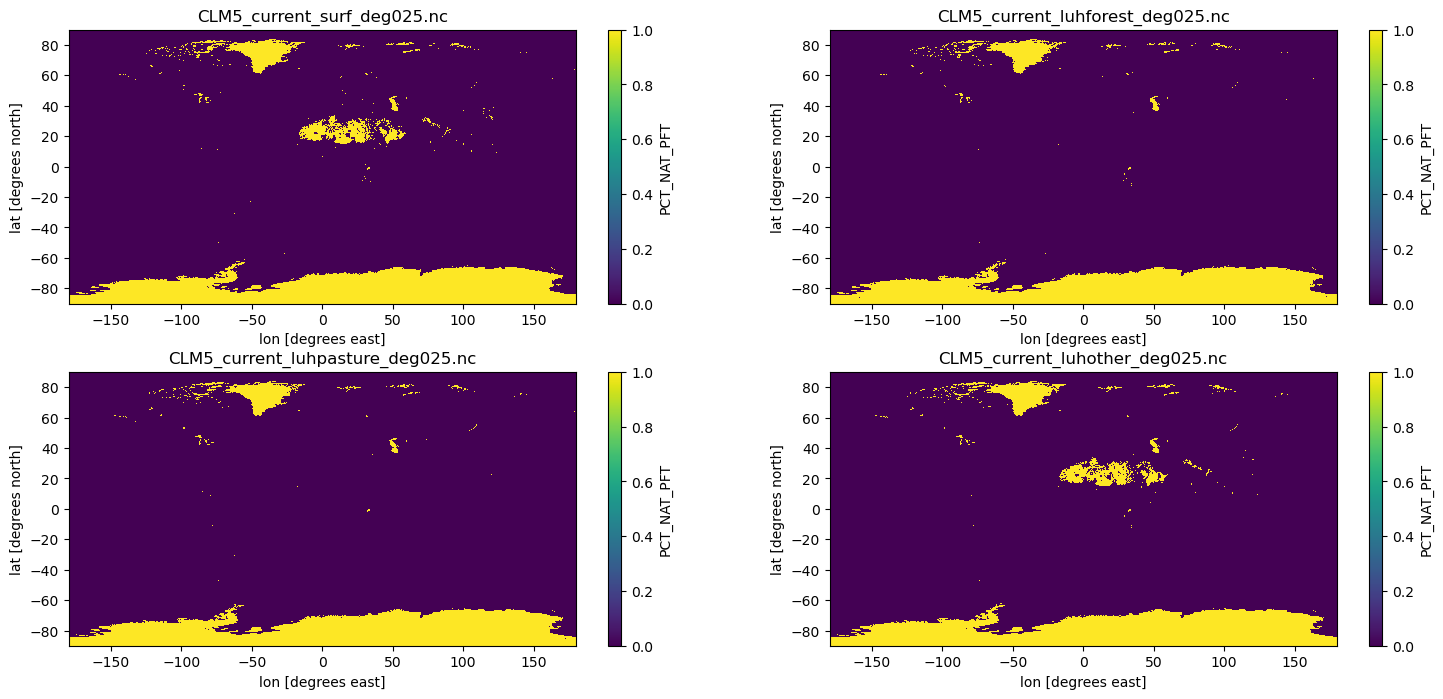

In [ ]:
mask_allbareground = []
f, ax = plt.subplots(2, 2, figsize=(18, 8))
plt.subplots_adjust(hspace=0.25)
for i,ai in enumerate(ax.flat):
    mask_allbareground.append(xr.where(bareground[i] == 100.,1,0))
    mask_allbareground[i].plot(ax=ai)
    ai.set_title(ds_clmlist[i].title)

### How do these 100% compare to each other?

CLM5_current_surf_deg025.nc
CLM5_current_luhforest_deg025.nc
CLM5_current_luhpasture_deg025.nc
CLM5_current_luhother_deg025.nc


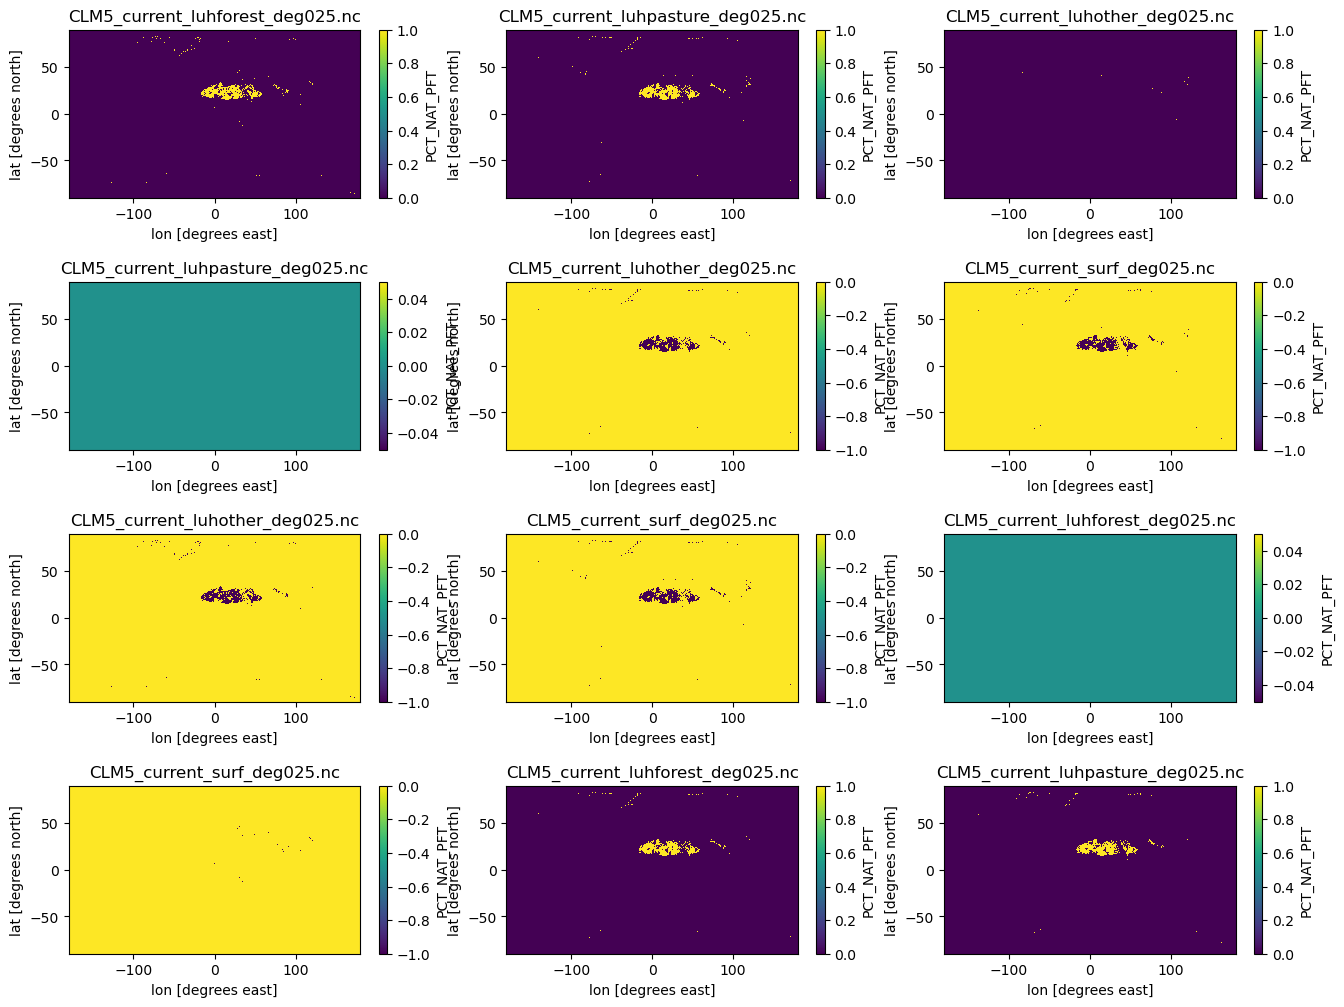

In [100]:
rows = 4
cols = 3
f, ax = plt.subplots(rows, cols, figsize=(16, 12))
plt.subplots_adjust(hspace=0.5)
idx = np.array([1,2,3,0])
for i,ai in enumerate(ax.flat):
    imod = np.mod(i,cols)
    if imod == 0:
        print(ds_clmlist[idx[-1]].title)
    (mask_allbareground[idx[-1]]-mask_allbareground[idx[imod]]).plot(ax=ai)
    ai.set_title(ds_clmlist[idx[imod]].title)
    if imod == 2:
        idx = np.roll(idx,-1)

**Forest and Pasture 100% bareground are the same**.  Surface has a few additional data points than Other.

## Compute where sum of landuse percent is zero

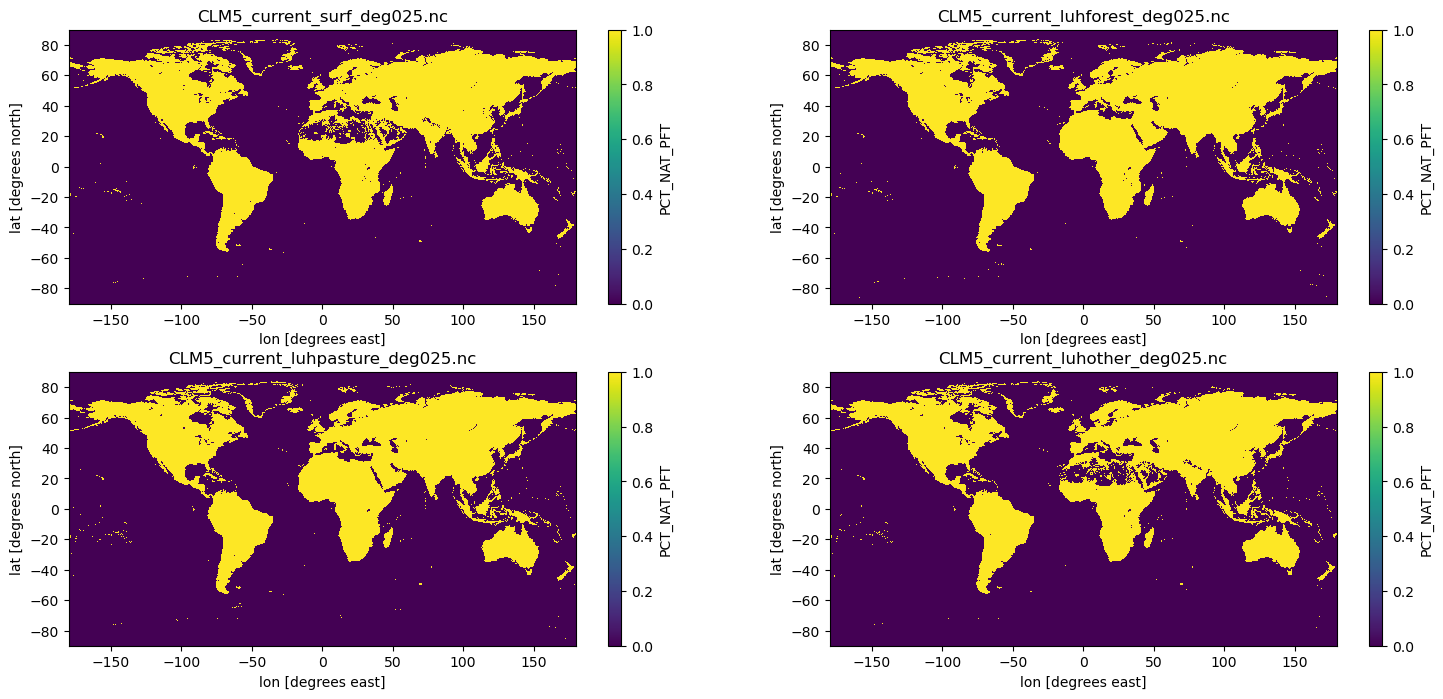

In [102]:
mask_zeropercent = []
f, ax = plt.subplots(2, 2, figsize=(18, 8))
plt.subplots_adjust(hspace=0.25)
for i,ai in enumerate(ax.flat):
    mask_zeropercent.append(xr.where(percent[i].sum(dim='natpft') == 0.,0,1))
    mask_zeropercent[i].plot(ax=ai)
    ai.set_title(ds_clmlist[i].title)

### How do these 0% landuse compare to each other?

CLM5_current_surf_deg025.nc
CLM5_current_luhforest_deg025.nc
CLM5_current_luhpasture_deg025.nc
CLM5_current_luhother_deg025.nc


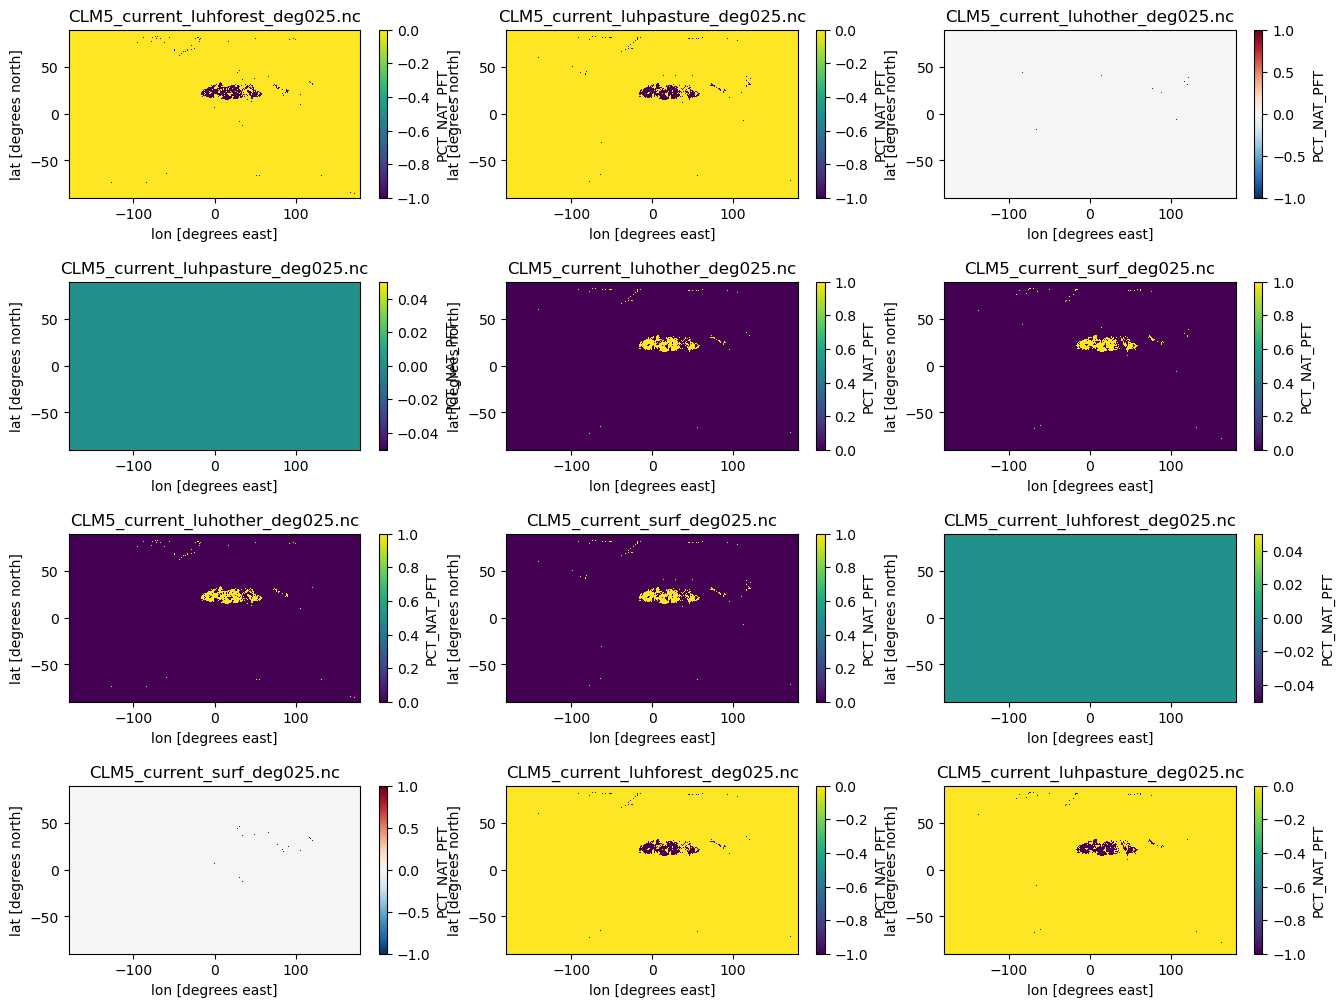

In [103]:
rows = 4
cols = 3
f, ax = plt.subplots(rows, cols, figsize=(16, 12))
plt.subplots_adjust(hspace=0.5)
idx = np.array([1,2,3,0])
for i,ai in enumerate(ax.flat):
    imod = np.mod(i,cols)
    if imod == 0:
        print(ds_clmlist[idx[-1]].title)
    (mask_zeropercent[idx[-1]]-mask_zeropercent[idx[imod]]).plot(ax=ai)
    ai.set_title(ds_clmlist[idx[imod]].title)
    if imod == 2:
        idx = np.roll(idx,-1)

**Again, pasture and forest landuse are the same**.  Surface and Other has some data missing from each, however, which is different from last time.

## How do the 100% bareground and 0% landuse compare?

Look at where they are the same and diff where they are different

In [130]:
for idx in range(4):
    print(ds_clmlist[idx].title)
    print("Is the muliplication of the 100% and 0% all zero: ", ((mask_zeropercent[idx] * mask_allbareground[idx]) == 0).all().values)
    print()

CLM5_current_surf_deg025.nc
Is the muliplication of the 100% and 0% all zero:  True

CLM5_current_luhforest_deg025.nc
Is the muliplication of the 100% and 0% all zero:  True

CLM5_current_luhpasture_deg025.nc
Is the muliplication of the 100% and 0% all zero:  True

CLM5_current_luhother_deg025.nc
Is the muliplication of the 100% and 0% all zero:  True



**Since the multiplication of the same for each landuse type is always zero, they have no overlap**.  Plot example below:

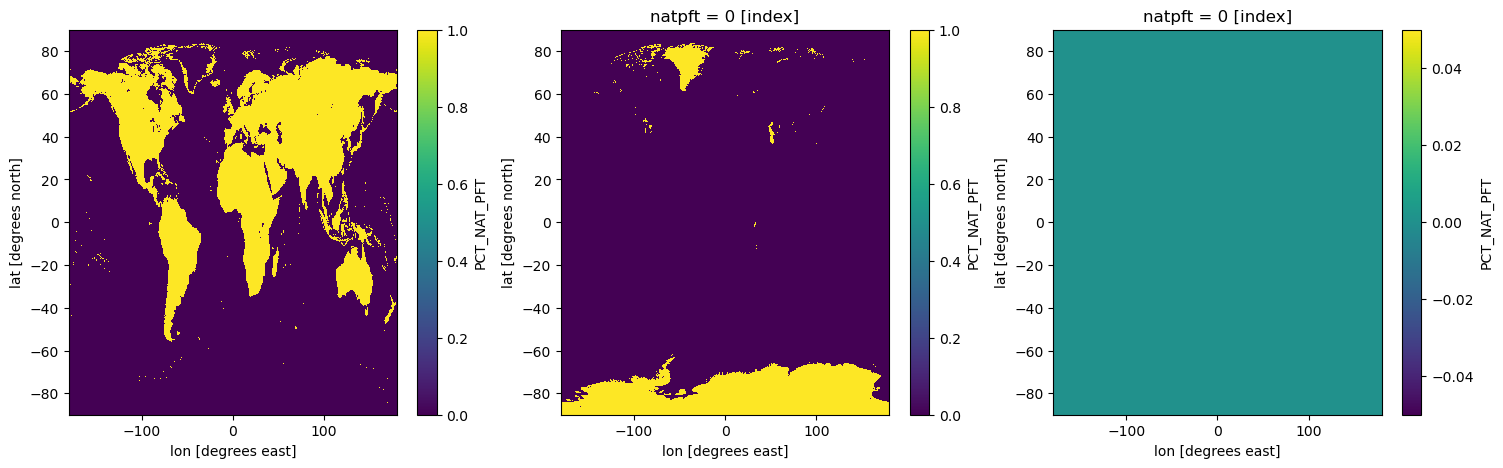

In [131]:
# Multiply to see where they are the same
idx = 2
f, ax = plt.subplots(1, 3, figsize=(18, 5))
mask_zeropercent[idx].plot(ax=ax[0])
mask_allbareground[idx].plot(ax=ax[1])
(mask_zeropercent[idx] * mask_allbareground[idx]).plot(ax=ax[2])

## TODO: Actually compare the forest+secondary masking

In [141]:
## (1) the ice/water mask
## (2) where the bare ground mask has Nan values
## (3) where the land is 100% bare ground
## (4) where there is missing data in the pasture lands

TODO: compare the clmsurface 100% bareground * the missing landuse